# Section 1 : Dataset Preparation and helper functions

In [1]:
from numpy.random import seed
seed(17)
from tensorflow import random
random.set_seed(17)

import pywt
import os
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils

import tensorflow as tf
from tensorflow.keras.applications.vgg19 import  VGG19
from tensorflow.keras.applications.vgg16 import  VGG16, preprocess_input


from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, Dropout, Lambda, GlobalAveragePooling2D,ZeroPadding2D
from keras.layers import Layer

from tensorflow.keras.optimizers import Adam, SGD,Nadam
import tensorflow.keras.backend as K


from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint


from skimage import exposure

from sklearn.metrics import  classification_report
from sklearn.metrics import confusion_matrix

# from keras.utils import plot_model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp -r /content/drive/MyDrive/major\ project/brain_tumor_dataset .

In [3]:
K.set_image_data_format('channels_first')
DATA_DIR = '/content/brain_tumor_dataset'
IMAGE_SIZE = (224,224)

In [4]:
#################
#DATA AUGMENTATION 
#################

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    rotation_range=45,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant',cval =  0,
    preprocessing_function = preprocess_input,
    validation_split=0.2) # set validation split


test_datagen = ImageDataGenerator(rescale=1./255,
    preprocessing_function = preprocess_input,
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='training') # set as training data

validation_generator = test_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=16,
    shuffle=False,
    subset='validation') # set as validation data

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [5]:
#Create Helper Functions



def plot_curves(hist):
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc,  label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title('Training and validation accuracy')

    plt.figure()

    plt.plot(epochs, loss,  label='Training Loss')
    plt.plot(epochs, val_loss,  label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


#Helper functions to evaluate and show results
def show_metrics(model):
    print("[INFO] evalutating network on holdout set...")
    predictions = model.predict(validation_generator)
    print(classification_report(validation_generator.classes, predictions.argmax(axis=1) ) )
    print(confusion_matrix(validation_generator.classes, predictions.argmax(axis=1)))
    tn, fp, fn, tp = confusion_matrix(validation_generator.classes, predictions.argmax(axis=1)).ravel()

    print("\n Precision:", (tp/(tp+fp)))
    print("\n Recall:" ,(tp/(tp+fn)))
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    print("\nError Rate:" ,1- accuracy)



#Helper function to plot model summary
    def plot_model_chart(model):
        plot_model(
            model, 
            to_file='model.png',
            show_shapes='true',
            dpi=96
        )


#VGC

### Training the VGG16 model with traditional maxpooling approach

In [6]:
def Create_model():
    base_vgg_model = VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=(3,224,224)
    )

    for layers in base_vgg_model.layers[:14]:
        layers.trainable = False

    x = base_vgg_model.output
    x=GlobalAveragePooling2D()(x)

    x = Dense(256, activation='relu')(x)
    x= Dropout(0.2)(x)
    predictions = Dense(2, activation='softmax')(x)

    # this is the model we will train
    vgg_model = Model(inputs=base_vgg_model.input, outputs=predictions)


    return vgg_model

In [7]:
vgg_model = Create_model()

#Control learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.1,
                              patience=5, min_lr=0.0001)

checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_acc',save_best_only=True, mode='auto')  #Save the best model

opt = Adam(lr=0.01)
vgg_model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['acc'])


58892288/58889256 [==============================] - 2s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Training loop
hist = vgg_model.fit(
    train_generator,
    validation_data = validation_generator, 
    epochs = 1000,
    verbose = 1,
    callbacks=[reduce_lr,checkpoint])

In [8]:
vgg_model.load_weights('/content/drive/MyDrive/major project/saved models/model ID 1-0.920000.h5')
show_metrics(vgg_model)

[INFO] evalutating network on holdout set...
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        19
           1       0.94      0.94      0.94        31

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50

[[17  2]
 [ 2 29]]

 Precision: 0.9354838709677419

 Recall: 0.9354838709677419

Error Rate: 0.07999999999999996


In [ ]:
vgg_model.optimizer.get_config()

{'decay': 0.0,
 'learning_rate': 1e-04,
 'momentum': 0.9,
 'name': 'SGD',
 'nesterov': False}

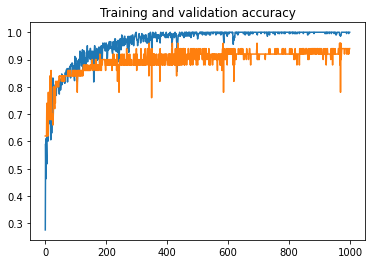

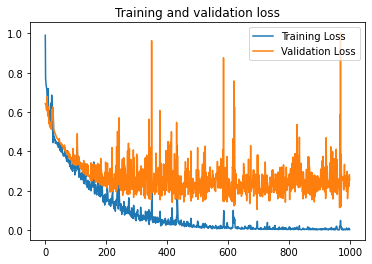



[INFO] evalutating network on holdout set...
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        19
           1       0.94      0.94      0.94        31

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50

[[17  2]
 [ 2 29]]

 Precision: 0.9354838709677419

 Recall: 0.9354838709677419

Error Rate: 0.07999999999999996


In [ ]:
plot_curves(hist)
print('\n')
show_metrics(vgg_model)

#Wavelet

<p> Let us define the DWT Pooling layer as a layer Class



In [9]:
#define the wavelet
#see pywt.wavelist(kind='discrete') for available wavelets 

wavelet = pywt.Wavelet('db1')
class DWT_Pooling(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(DWT_Pooling, self).__init__(**kwargs)
        
    def build(self, input_shape):
        super(DWT_Pooling, self).build(input_shape) 
    
    @tf.function
    def call(self, inputs):
        band_low = wavelet.rec_lo
        band_high = wavelet.rec_hi
        assert len(band_low) == len(band_high)
        band_length = len(band_low)
        assert band_length % 2 == 0
        band_length_half = math.floor(band_length / 2)

        input_height = inputs.shape[2]
        input_width = inputs.shape[3]

        L1 = input_height
        L = math.floor(L1 / 2)
        matrix_h = np.zeros( ( L,      L1 + band_length - 2 ), dtype=np.float32)
        matrix_g = np.zeros( ( L1 - L, L1 + band_length - 2 ), dtype=np.float32)
        end = None if band_length_half == 1 else (-band_length_half+1)
        
        index = 0
        for i in range(L):
            for j in range(band_length):
                matrix_h[i, index+j] = band_low[j]
            index += 2
        matrix_h_0 = matrix_h[0:(math.floor(input_height / 2)), 0:(input_height + band_length - 2)]
        matrix_h_1 = matrix_h[0:(math.floor(input_width / 2)), 0:(input_width + band_length - 2)]

        index = 0
        for i in range(L1 - L):
            for j in range(band_length):
                matrix_g[i, index+j] = band_high[j]
            index += 2

        matrix_g_0 = matrix_g[0:(input_height - math.floor(input_height / 2)),0:(input_height + band_length - 2)]
        matrix_g_1 = matrix_g[0:(input_width - math.floor(input_width / 2)),0:(input_width + band_length - 2)]

        matrix_h_0 = matrix_h_0[:,(band_length_half-1):end]
        matrix_h_1 = matrix_h_1[:,(band_length_half-1):end]
        matrix_h_1 = np.transpose(matrix_h_1)
        matrix_g_0 = matrix_g_0[:,(band_length_half-1):end]
        matrix_g_1 = matrix_g_1[:,(band_length_half-1):end]
        matrix_g_1 = np.transpose(matrix_g_1)

        matrix_low_0 = tf.convert_to_tensor(matrix_h_0,dtype=tf.float32)
        matrix_low_1 = tf.convert_to_tensor(matrix_h_1,dtype=tf.float32)
        matrix_high_0 = tf.convert_to_tensor(matrix_g_0,dtype=tf.float32)
        matrix_high_1 = tf.convert_to_tensor(matrix_g_1,dtype=tf.float32)
        
        L = tf.matmul(matrix_low_0, inputs)
        H = tf.matmul(matrix_high_0, inputs)


        LL = tf.matmul(L, matrix_low_1) #Create a subsample 
        LH = tf.matmul(L, matrix_high_1) #Recognises Vertical edges
        HL = tf.matmul(H, matrix_low_1) #Recognises Horizontal edges
        HH = tf.matmul(H, matrix_high_1) #Recognises Diagnoal edges
        return LL    
    
    def get_config(self):
        config = super(DWT_Pooling, self).get_config()
        return config

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2]//2, input_shape[3]//2)

# VGG Wavelet Pooling Model

In [10]:
def Create_wavelet_model_V2():
    base_vgg_model = VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=(3,224,224)
    )

    #Create new Sequential model
    vgg_wavelet_model  = Sequential()

    #Add layers from vgg_model upto block4_conv
    for layer in base_vgg_model.layers[:14]:
        vgg_wavelet_model.add(layer)

    #Add DWT pooling layer
    vgg_wavelet_model.add(DWT_Pooling())

    #Add additonal conv layer
    vgg_wavelet_model.add(Conv2D(512, (3, 3), activation='relu',padding='same'))

    #Add DWT layer
    vgg_wavelet_model.add(DWT_Pooling())

    vgg_wavelet_model.add(Flatten())
    vgg_wavelet_model.add(Dense(512, activation='relu'))
    vgg_wavelet_model.add(Dense(512, activation='relu'))

    # vgg_wavelet_model.add(Dense(512, activation='relu'))
    vgg_wavelet_model.add(Dropout(0.2))
    vgg_wavelet_model.add(Dense(2, activation='softmax', name='predictions'))

    for layer in vgg_wavelet_model.layers[:14]:
        layer.trainable = False
        
    # vgg_wavelet_model.summary()
    return vgg_wavelet_model

In [ ]:
# !cp /content/drive/MyDrive/major\ project/model-100-0.950739-0.900000.h5 .
# !cp /content/drive/MyDrive/major\ project/saved\ models/Copy\ of\ model\ ID\ 2-0.960000.h5 .

cp: cannot stat '/content/drive/MyDrive/major project/saved models/Copy of model ID 2-0.960000.h5': No such file or directory


In [11]:

model = Create_wavelet_model_V2()

reduce_lr = ReduceLROnPlateau(
                                monitor='val_acc', 
                                factor=0.1,
                                patience=5, 
                                min_lr=0.0001,
                                verbose=1)


checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_acc',save_best_only=True, mode='auto')

# opt = Adam(learning_rate=0.01)
opt = SGD(learning_rate=0.001)

model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['acc'])
# model.summary()

In [ ]:
hist_wav = model.fit(
    train_generator,
    validation_data = validation_generator, 
    epochs = 50,
    verbose = 1,
    steps_per_epoch = len(train_generator),
    callbacks=[reduce_lr,checkpoint])

Epoch 1/50
7/7 [==============================] - 3s 358ms/step - loss: 0.2663 - acc: 0.9064 - val_loss: 0.3419 - val_acc: 0.8400

Epoch 00001: val_acc did not improve from 0.86000
Epoch 2/50
7/7 [==============================] - 3s 351ms/step - loss: 0.2589 - acc: 0.9064 - val_loss: 0.3597 - val_acc: 0.8400

Epoch 00002: val_acc did not improve from 0.86000
Epoch 3/50
7/7 [==============================] - 3s 350ms/step - loss: 0.2213 - acc: 0.9113 - val_loss: 0.3487 - val_acc: 0.8400

Epoch 00003: val_acc did not improve from 0.86000
Epoch 4/50
7/7 [==============================] - 3s 351ms/step - loss: 0.2376 - acc: 0.9212 - val_loss: 0.3434 - val_acc: 0.8400

Epoch 00004: val_acc did not improve from 0.86000
Epoch 5/50
7/7 [==============================] - 3s 353ms/step - loss: 0.2360 - acc: 0.9212 - val_loss: 0.3424 - val_acc: 0.8400

Epoch 00005: val_acc did not improve from 0.86000
Epoch 6/50
7/7 [==============================] - 3s 354ms/step - loss: 0.2631 - acc: 0.9212 - 

In [ ]:
plot_curves(hist_wav)
model.optimizer.get_config()

In [12]:
model.load_weights('/content/drive/MyDrive/major project/saved models/model ID 2-0.960000.h5')
show_metrics(model)

[INFO] evalutating network on holdout set...
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        19
           1       0.97      0.97      0.97        31

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50

[[18  1]
 [ 1 30]]

 Precision: 0.967741935483871

 Recall: 0.967741935483871

Error Rate: 0.040000000000000036


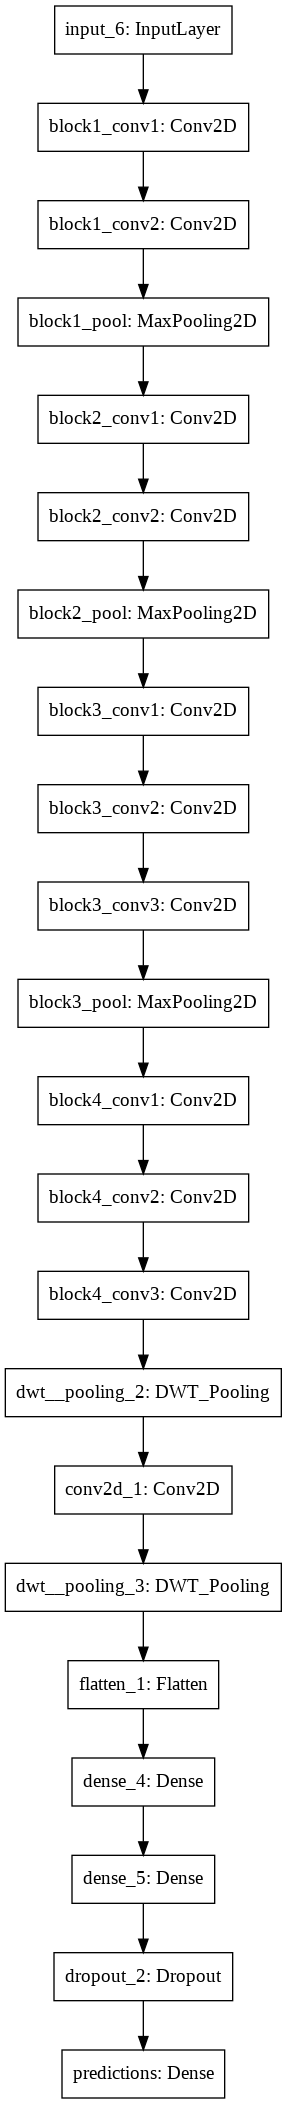

In [ ]:
plot_model(model)